# Titanic Survival Prediction

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [21]:
X = df.drop(columns=['deck', 'embarked', 'embark_town', 'alive', 'survived'], axis=1)
y = df['survived']

In [22]:
y.value_counts()

survived
0    549
1    342
Name: count, dtype: int64

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

<h3>Differentiating Features & Creating Separate Preprocessing Pipelines</h3>

In [24]:
num_feat = X_train.select_dtypes(include=['number']).columns.tolist()
cat_feat = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('s_sc', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

## Prediction using Random Forest Classifier
<h3>Combining Transformers & Creating a Model Pipeline</h3>

In [25]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_feat),
        ('cat', cat_transformer, cat_feat)
    ]
)

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

<h3>Defining Parameters for Cross-Validation</h3>

In [26]:
# Defining Parameter Grid
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split':[2, 5]
}

# Cross-Validation method
cv = StratifiedKFold(n_splits=5, shuffle=True)

<h3>Training, Testing & Evaluating Model</h3>

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       110
           1       0.81      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



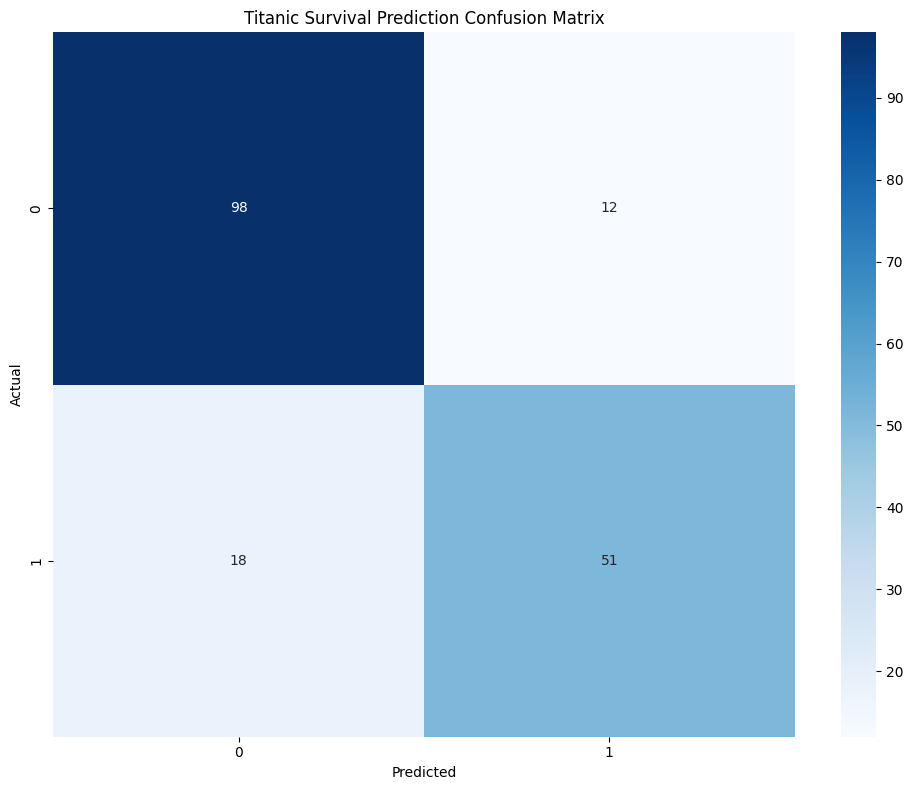

In [27]:
# Training pipeline model
model = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=cv, scoring='accuracy')
model.fit(X_train, y_train)

# Model Prediction
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Titanic Survival Prediction Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

<h3>Feature Importance</h3>

In [28]:
feature_imp = model.best_estimator_['classifier'].feature_importances_

feature_names = num_feat + list(model.best_estimator_['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_feat))
feature_names

['pclass',
 'age',
 'sibsp',
 'parch',
 'fare',
 'sex_female',
 'sex_male',
 'class_First',
 'class_Second',
 'class_Third',
 'who_child',
 'who_man',
 'who_woman']

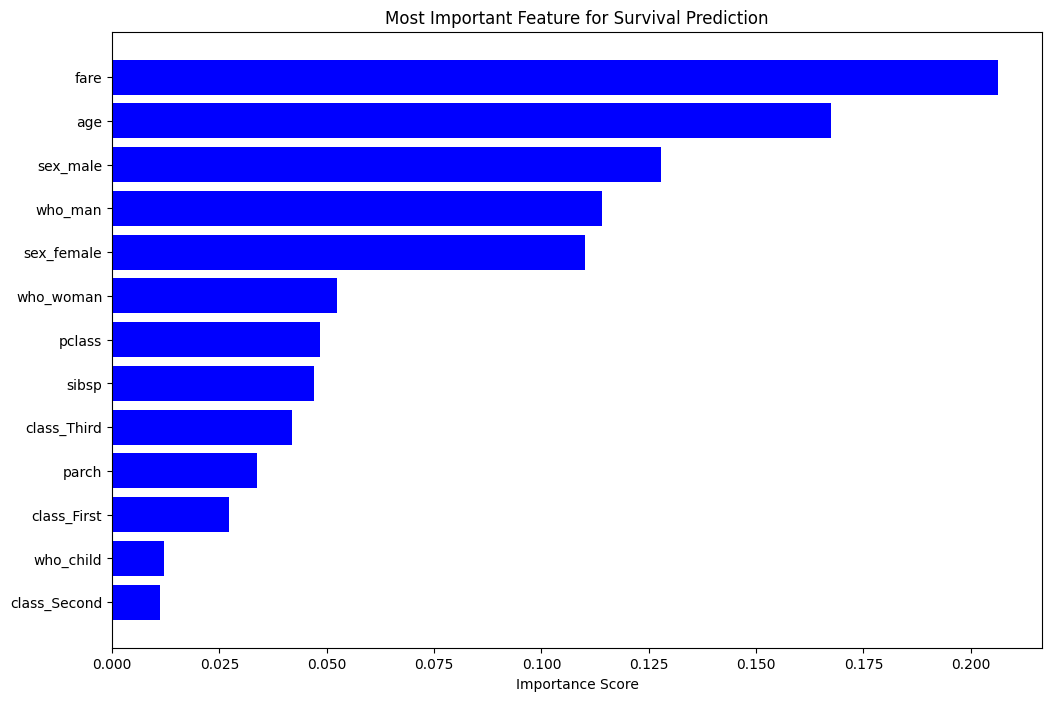

Test set accuracy:0.83


In [29]:
imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_imp
    }).sort_values(by='Importance')

plt.figure(figsize=(12, 8))
plt.barh(imp_df['Feature'], imp_df['Importance'], color='blue')
plt.title('Most Important Feature for Survival Prediction')
plt.xlabel('Importance Score')
plt.show()

test_score = model.score(X_test, y_test)
print('Test set accuracy:%.2f' % test_score)

## Prediction using Logistic Regression

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       110
           1       0.81      0.72      0.76        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179



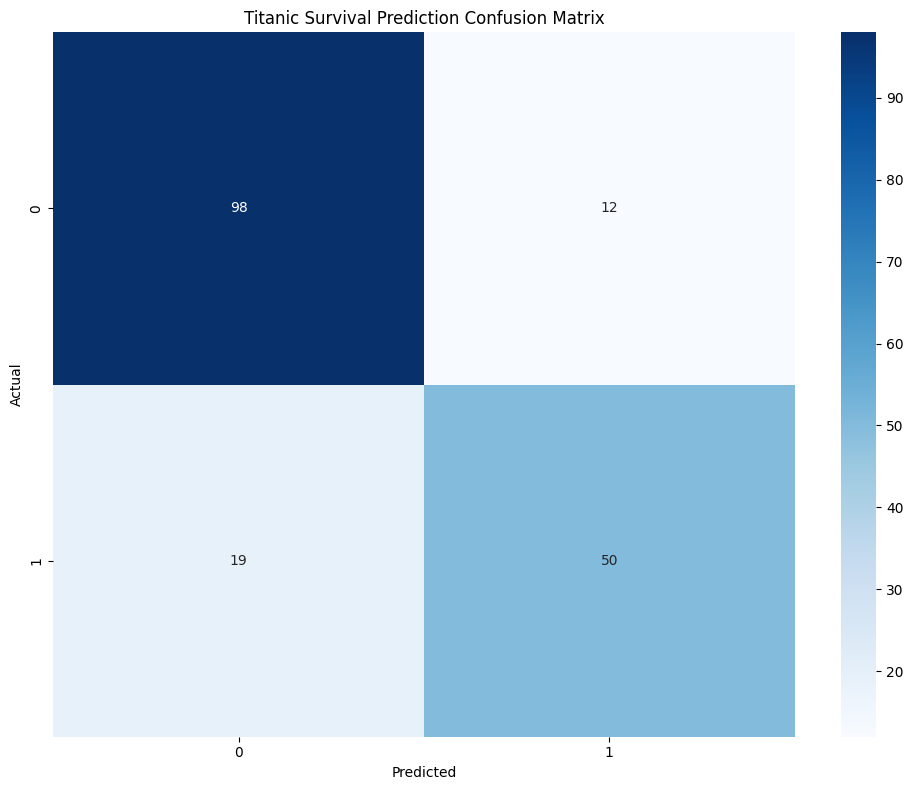

In [30]:
pipe.set_params(classifier=LogisticRegression(random_state=42))
model.estimator = pipe

param_grid = {
    'classifier__solver': ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__class_weight': [None, 'balanced']
}
model.param_grid = param_grid

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Titanic Survival Prediction Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

<h3>Extracting Feature Coefficients</h3>

In [31]:
coeff = model.best_estimator_.named_steps['classifier'].coef_[0]

feature_names = num_feat + list(model.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_feat))

<h3>Feature Importance</h3>

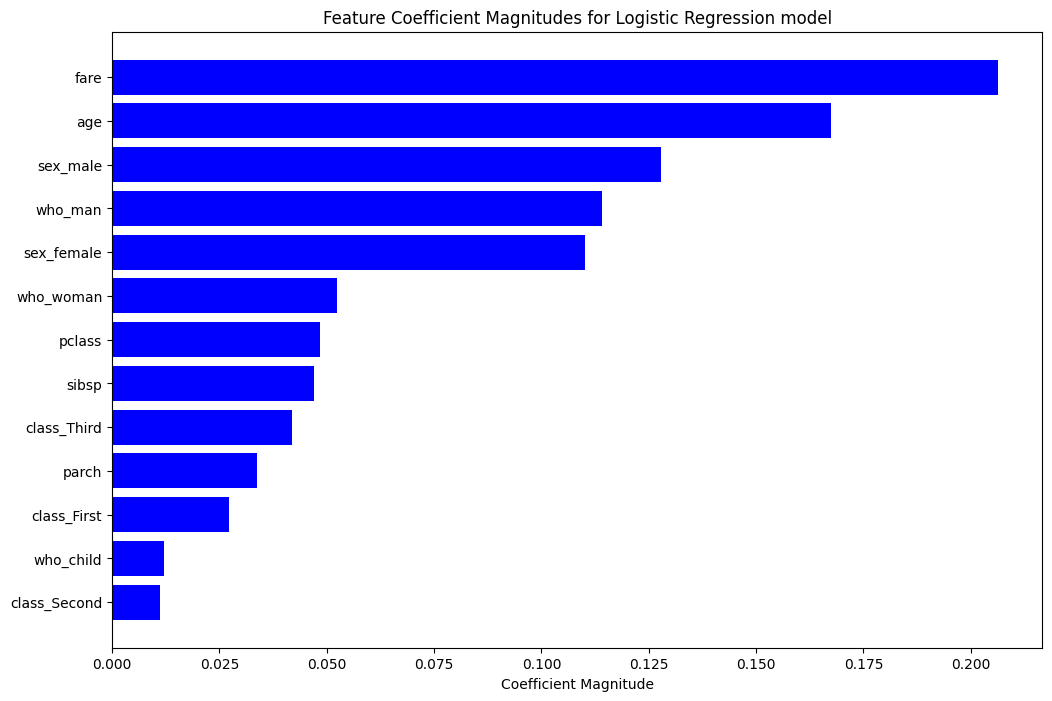

Test set accuracy: 0.83


In [32]:
imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_imp
}).sort_values(by='Importance', key=abs)

plt.figure(figsize=(12, 8))
plt.barh(imp_df['Feature'], imp_df['Importance'].abs(), color='blue')
plt.title('Feature Coefficient Magnitudes for Logistic Regression model')
plt.xlabel('Coefficient Magnitude')
plt.show()

test_score = model.best_estimator_.score(X_test, y_test)
print('Test set accuracy: %.2f' % test_score)